Perform statistical analyses of metrics computed in 3A.

In [1]:
%matplotlib inline
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from sklearn import linear_model

from disp import set_font_size


LOAD_DIR = 'data_/_RESULTS/ODOR_TRACKING'
SAVE_DIR = 'data_/_RESULTS/ODOR_TRACKING_STATS'
EXPT = 'CL_360_LOWFLOW_ACV'
# EXPT = 'CL_180_HighFlow_ACV'

if not os.path.exists(SAVE_DIR):
    os.makedirs(SAVE_DIR)

# Quick sanity check

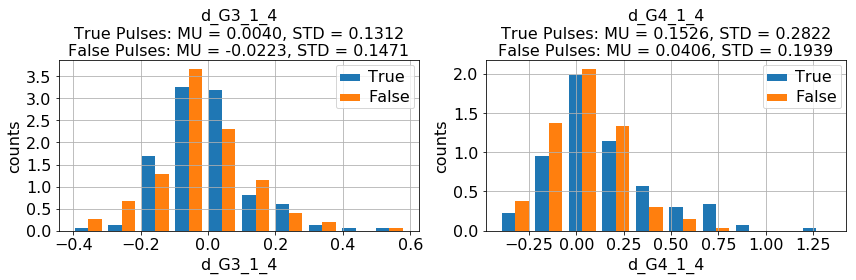

In [2]:
# distribution of G3 and G4 responses to odor
metrics = pd.read_csv(os.path.join(LOAD_DIR, '{}_METRICS.csv'.format(EXPT)), index_col=0)
metrics_ctls = {}

for ctl_offset in [-10, -20, -30]:
    metrics_ctls[ctl_offset] = pd.read_csv(
        os.path.join(LOAD_DIR, '{}_METRICS_FALSE_ODOR_OFFSET_{}.csv'.format(EXPT, ctl_offset)), index_col=0)

fig, axs = plt.subplots(1, 2, figsize=(12, 4), tight_layout=True)

for ax, k in zip(axs, ['d_G3_1_4', 'd_G4_1_4']):
    
    ax.hist(np.array([metrics[k], metrics_ctls[-10][k]]).T, normed=True)
    ax.set_xlabel(k)
    ax.set_ylabel('counts')
    ax.set_title('{4}\nTrue Pulses: MU = {0:.4f}, STD = {1:.4f}\nFalse Pulses: MU = {2:.4f}, STD = {3:.4f}'.format(
        np.nanmean(metrics[k]), np.nanstd(metrics[k]),
        np.nanmean(metrics_ctls[-10][k]), np.nanstd(metrics_ctls[-10][k]), k))
    ax.legend(['True', 'False'])


for ax in axs:
    ax.grid()
    set_font_size(ax, 16)

# Nested model analysis

Explaining neural.

In [3]:
factors = ['None', 'h_neg10_0', 'd_v_1_4', 'd_h_1_4', 'd_h_7_10']

for ctl_offset in [0, -10, -20, -30]:

    if not ctl_offset:
        metrics_filt = metrics[metrics['Include'] == 'Include'].dropna()
    else:
        metrics_filt = metrics_ctls[ctl_offset][metrics_ctls[ctl_offset]['Include'] == 'Include'].dropna()
        
    for gx in ['G2', 'G3', 'G4', 'G5']:

        print('{}:'.format(gx))

        targ = 'd_{}_1_4'.format(gx)
        y = metrics_filt[targ]

        # reduced factors
        factors_r = []

        # track residual variances, f-vals, and p-vals
        res_vars = [np.nanvar(y)]
        fs = [np.nan]
        ps = [np.nan]

        for ctr, factor in enumerate(factors[1:]):

            # fit reduced model
            if ctr == 0:
                y_hat_r = np.nanmean(y)
            else:
                xs_r = metrics_filt[factors_r]
                rgr_r = linear_model.LinearRegression().fit(xs_r, y)
                y_hat_r = rgr_r.predict(xs_r)

            # fit full model
            factors_f = factors_r + [factor]
            xs_f = metrics_filt[factors_f]
            rgr_f = linear_model.LinearRegression().fit(xs_f, y)
            y_hat_f = rgr_f.predict(xs_f)

            print('CTR = {}'.format(ctr))
            print('FACTORS_R = {}'.format(factors_r))
            print('FACTORS_F = {}'.format(factors_f))

            # calc variance of residual 
            res_var = np.nanvar(y - y_hat_f)
            res_vars.append(res_var)

            # calc f & p val btwn reduced and full
            n = len(y)

            rss_r = np.sum((y - y_hat_r)**2)
            rss_f = np.sum((y - y_hat_f)**2)

            # params
            p_r = ctr + 1
            p_f = ctr + 2

            # degs freedom
            dfn = p_f - p_r
            dfd = n - p_f

            # compute F
            f = ((rss_r - rss_f) / (p_f - p_r)) / (rss_f / (n - p_f))

            # compute p_val
            p = stats.f.sf(f, dfn, dfd)

            fs.append(f)
            ps.append(p)

            # make current full factor set be next reduced factor set
            factors_r = factors_f

        print('P = {}'.format(ps))

        df_save = pd.DataFrame(
            data={'FACTORS': factors, 'RES_VAR': res_vars, 'F': fs, 'P': ps},
            columns=['FACTORS', 'RES_VAR', 'F', 'P'])

        if not ctl_offset:
            fn = '{}_{}_FROM_NESTED.csv'.format(EXPT, targ)
        else:
            fn = '{}_{}_FROM_NESTED_FALSE_ODOR_OFFSET_{}.csv'.format(EXPT, targ, ctl_offset)
            
        df_save.to_csv(os.path.join(SAVE_DIR, fn), index=False, na_rep='NaN')

G2:
CTR = 0
FACTORS_R = []
FACTORS_F = ['h_neg10_0']
CTR = 1
FACTORS_R = ['h_neg10_0']
FACTORS_F = ['h_neg10_0', 'd_v_1_4']
CTR = 2
FACTORS_R = ['h_neg10_0', 'd_v_1_4']
FACTORS_F = ['h_neg10_0', 'd_v_1_4', 'd_h_1_4']
CTR = 3
FACTORS_R = ['h_neg10_0', 'd_v_1_4', 'd_h_1_4']
FACTORS_F = ['h_neg10_0', 'd_v_1_4', 'd_h_1_4', 'd_h_7_10']
P = [nan, 0.013617839018961233, 0.017568832398522242, 0.2781917189226799, 0.0017363089807892699]
G3:
CTR = 0
FACTORS_R = []
FACTORS_F = ['h_neg10_0']
CTR = 1
FACTORS_R = ['h_neg10_0']
FACTORS_F = ['h_neg10_0', 'd_v_1_4']
CTR = 2
FACTORS_R = ['h_neg10_0', 'd_v_1_4']
FACTORS_F = ['h_neg10_0', 'd_v_1_4', 'd_h_1_4']
CTR = 3
FACTORS_R = ['h_neg10_0', 'd_v_1_4', 'd_h_1_4']
FACTORS_F = ['h_neg10_0', 'd_v_1_4', 'd_h_1_4', 'd_h_7_10']
P = [nan, 0.14265347623652186, 0.9183576948390828, 0.5833248673310849, 0.0013622675447797247]
G4:
CTR = 0
FACTORS_R = []
FACTORS_F = ['h_neg10_0']
CTR = 1
FACTORS_R = ['h_neg10_0']
FACTORS_F = ['h_neg10_0', 'd_v_1_4']
CTR = 2
FACTORS_R =

## Make plots

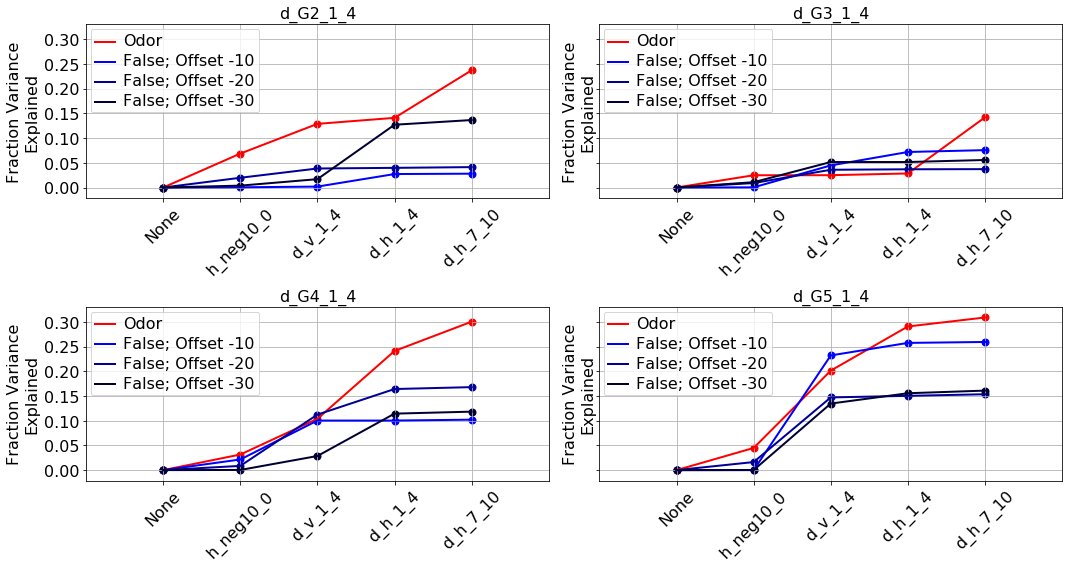

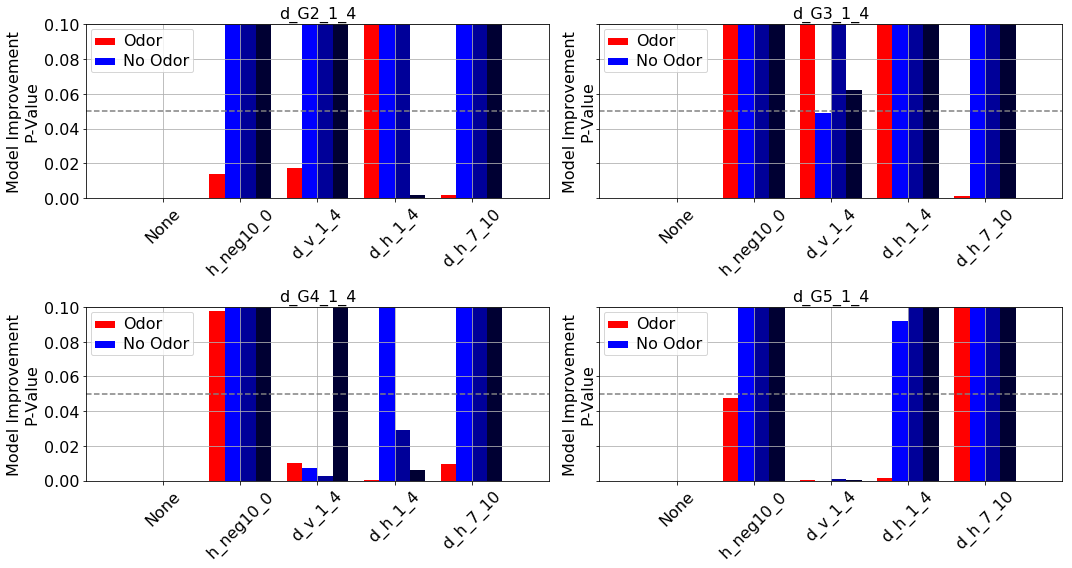

In [4]:
ctl_colors = {-10: (0, 0, 1), -20: (0, 0, .6), -30: (0, 0, .2)}
x_lim = (-1, 5)

fig, axs = plt.subplots(2, 2, figsize=(15, 8), tight_layout=True, sharey=True)
fig_p, axs_p = plt.subplots(2, 2, figsize=(15, 8), tight_layout=True, sharey=True)


for ax, ax_p, gx in zip(axs.flat, axs_p.flat, ['G2', 'G3', 'G4', 'G5']):
    targ = 'd_{}_1_4'.format(gx)
    
    # explained variance
    
    ## true
    df = pd.read_csv(os.path.join(SAVE_DIR, '{}_{}_FROM_NESTED.csv'.format(EXPT, targ)))
    
    ## control
    df_ctls = {}
    for ctl_offset in [-10, -20, -30]:
        df_ctls[ctl_offset] = pd.read_csv(
            os.path.join(SAVE_DIR, '{}_{}_FROM_NESTED_FALSE_ODOR_OFFSET_{}.csv'.format(EXPT, targ, ctl_offset)))
    
    var = df['RES_VAR']
    var = (1 - var/var.max())
    
    # true
    ax.plot(np.arange(len(df)), var, color='r', lw=2)
    ax.scatter(np.arange(len(df)), var, color='r', lw=2)
    
    # controls
    for ctl_offset in [-10, -20, -30]:
        var_ctl = df_ctls[ctl_offset]['RES_VAR']
        var_ctl = (1 - var_ctl/var_ctl.max())
        
        ax.plot(np.arange(len(df)), var_ctl, color=ctl_colors[ctl_offset], lw=2)
        ax.scatter(np.arange(len(df)), var_ctl, color=ctl_colors[ctl_offset], lw=2)
    
    ax.set_xlim(x_lim)
    
    ax.set_xticks(np.arange(len(df)))
    ax.set_xticklabels(df['FACTORS'], rotation=45)
    
    ax.set_ylabel('Fraction Variance\nExplained')
    ax.set_title(targ)
    
    ax.legend(['Odor'] + ['False; Offset {}'.format(ctl_offset) for ctl_offset in [-10, -20, -30]], loc='upper left')
    
    ax.grid()
    set_font_size(ax, 16)
    
    # p-vals
    for co_ctr, ctl_offset in enumerate([-10, -20, -30]):
        x_offset = co_ctr * .2
        
        ax_p.bar(
            np.arange(len(df)) - .4, df['P'], align='edge', width=.2, color='r', lw=2)
        ax_p.bar(
            np.arange(len(df)) - .2 + x_offset, df_ctls[ctl_offset]['P'],
            align='edge', width=.2, color=ctl_colors[ctl_offset], lw=2)
        
    ax_p.legend(['Odor', 'No Odor'], loc='upper left')
    
    ax_p.axhline(0.05, color='gray', ls='--')
    
    ax_p.set_xlim(x_lim)
    ax_p.set_ylim(0, 0.1)
    
    ax_p.set_xticks(np.arange(len(df)))
    ax_p.set_xticklabels(df['FACTORS'], rotation=45)
    
    ax_p.set_ylabel('Model Improvement\nP-Value')
    ax_p.set_title(targ)
    
    ax_p.grid()
    set_font_size(ax_p, 16)
    
fig.savefig(os.path.join(SAVE_DIR, '{}_GX_FROM_NESTED.pdf'.format(EXPT)))
fig_p.savefig(os.path.join(SAVE_DIR, '{}_GX_FROM_NESTED_P.pdf'.format(EXPT)))

# Orienting figures

Plot example traces of odor-triggered DANs & behavior.

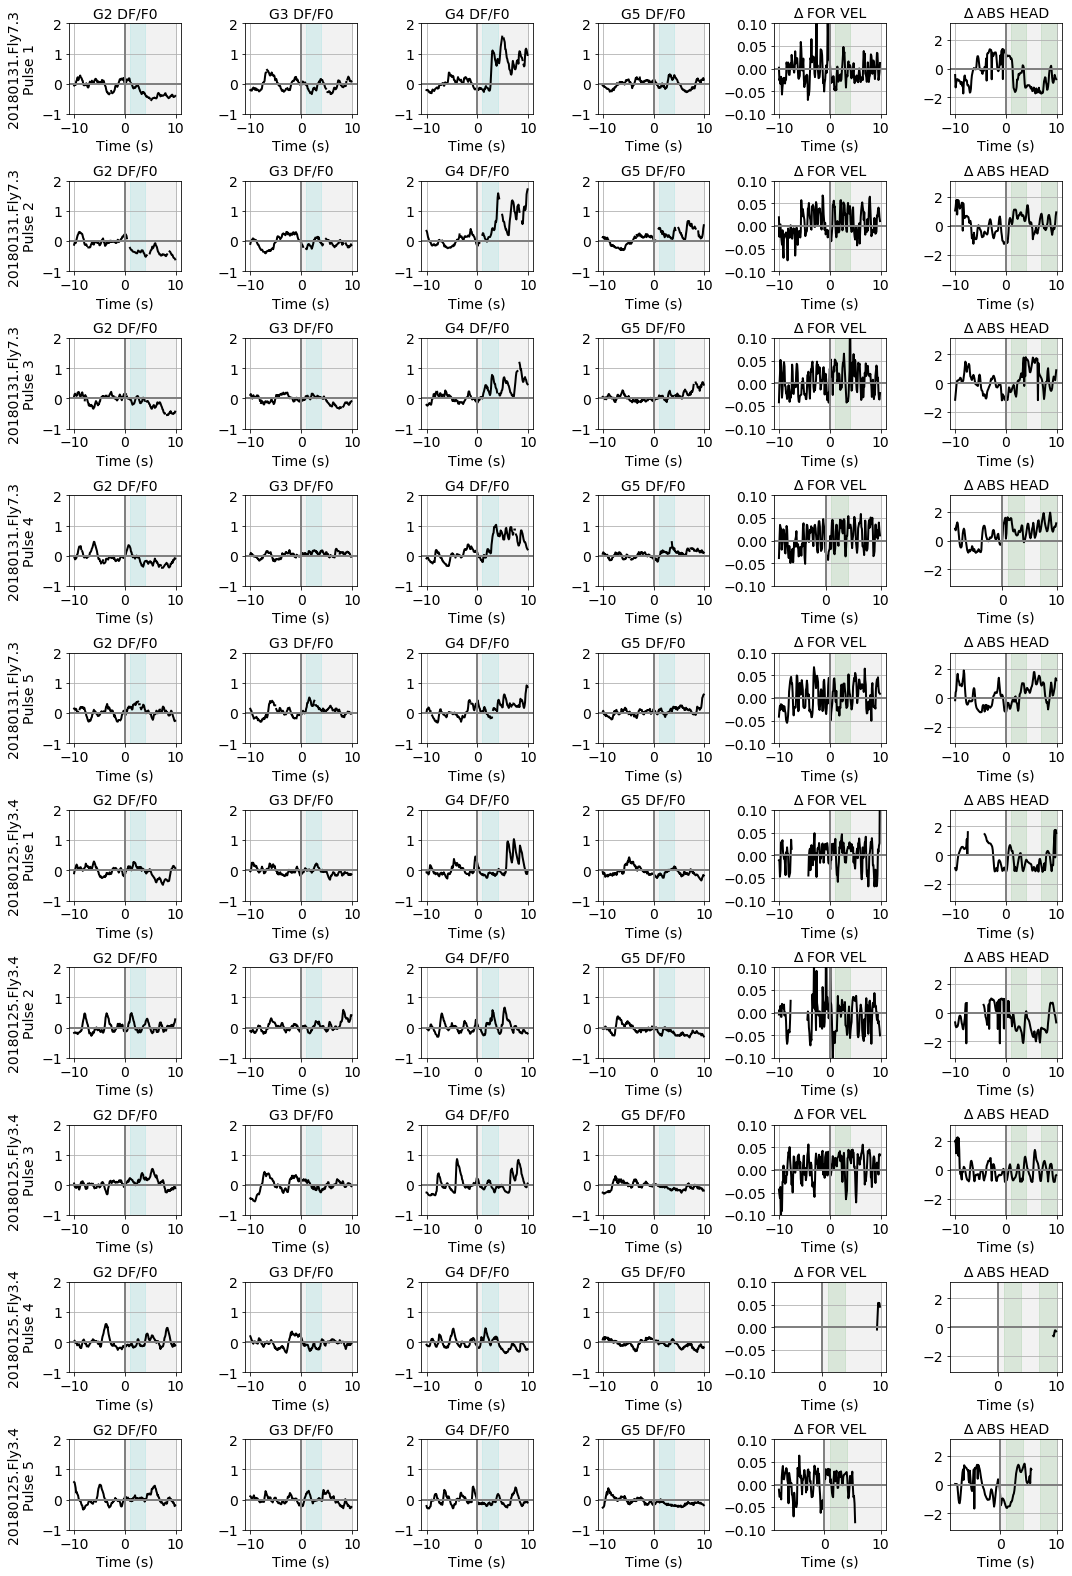

In [5]:
p_ids = range(10)
VARS = ['DFF0G2', 'DFF0G3', 'DFF0G4', 'DFF0G5', 'DELTAFORVEL', 'DELTAABSHEADING']
labels = {
    'DFF0G2': 'G2 DF/F0',
    'DFF0G3': 'G3 DF/F0',
    'DFF0G4': 'G4 DF/F0',
    'DFF0G5': 'G5 DF/F0',
    'DELTAFORVEL': '∆ FOR VEL',
    'DELTAABSHEADING': '∆ ABS HEAD',
}

# load all data
dfs = {}
for var in VARS:
    dfs[var] = pd.read_csv(os.path.join(LOAD_DIR, '{}_ODOR_TRIG_{}.csv'.format(EXPT, var)), index_col=0)
    
fig, axs = plt.subplots(len(p_ids), 6, figsize=(15, 2.2*len(p_ids)), tight_layout=True)

for ax_row, p_id in zip(axs, p_ids):
    trial = dfs[VARS[0]].loc[p_id]['Trial']
    p_ctr = dfs[VARS[0]].loc[p_id]['PulseCounter']
        
    for ctr, (ax, var) in enumerate(zip(ax_row, VARS)):
        
        trial_ = dfs[var].loc[p_id]['Trial']
        p_ctr_ = dfs[var].loc[p_id]['PulseCounter']
        
        assert trial_ == trial
        assert p_ctr_ == p_ctr
        
        t = dfs[var].columns[3:]
        ax.plot(t, dfs[var].loc[p_id][3:], color='k', lw=2)
        
        ax.axhline(0, color='gray', lw=2)
        ax.axvline(0, color='gray', lw=2)
        ax.axvspan(0, 10, color='gray', alpha=0.1)
        
        if var in ['DFF0G2', 'DFF0G3', 'DFF0G4', 'DFF0G5']:
            ax.axvspan(1, 4, color='c', alpha=0.1)
            ax.set_ylim(-1, 2)
        elif var == 'DELTAFORVEL':
            ax.axvspan(1, 4, color='g', alpha=0.1)
            ax.set_ylim(-.1, .1)
        elif var == 'DELTAABSHEADING':
            ax.axvspan(1, 4, color='g', alpha=0.1)
            ax.axvspan(7, 10, color='g', alpha=0.1)
            ax.set_ylim(-np.pi, np.pi)
            
        ax.set_xlabel('Time (s)')
        
        if ctr == 0:
            ax.set_ylabel('{}\nPulse {}'.format(trial, p_ctr+1))
        ax.grid()
        ax.set_title(labels[var])
        
        set_font_size(ax, 14)
        
fig.savefig(os.path.join(SAVE_DIR, '{}_ODOR_TRIG_EXAMPLES.pdf'.format(EXPT)))

# Full neural-heading cross-correlation matrices

In [6]:
VARS = ['DFF0G2', 'DFF0G3', 'DFF0G4', 'DFF0G5', 'FORVEL', 'ABSHEADING']
labels = {
    'DFF0G2': 'G2 DF/F0',
    'DFF0G3': 'G3 DF/F0',
    'DFF0G4': 'G4 DF/F0',
    'DFF0G5': 'G5 DF/F0',
    'FORVEL': 'FOR VEL',
    'ABSHEADING': 'ABS HEAD',
}

# loop over false odor times
for ctl_offset in [0, -10, -20, -30]:
    
    # load all data
    dfs = {}
    for var in VARS:
        if not ctl_offset:  # true odor pulses
            fn = '{}_ODOR_TRIG_{}.csv'.format(EXPT, var)
        else:
            fn = '{}_ODOR_TRIG_{}_FALSE_ODOR_OFFSET_{}.csv'.format(EXPT, var, ctl_offset)
            
        df = pd.read_csv(os.path.join(LOAD_DIR, fn), index_col=0)
        dfs[var] = df  # [df['Include'] == 'Include']

    t = dfs[VARS[0]].columns[3:].astype(float)

    rs_all = {}
    ps_all = {}
    ns_all = {}

    # cross correlations
    ## loop over behavs
    for behav in ['FORVEL', 'ABSHEADING']:

        # get behav matrix
        behav_mat = np.array(dfs[behav])[:, 3:].astype(float)

        # loop over DANs
        for gx in ['DFF0G2', 'DFF0G3', 'DFF0G4', 'DFF0G5']:

            # get DAN mat
            gx_mat = np.array(dfs[gx])[:, 3:].astype(float)

            # compute timepoint-by-timepoint correlations
            rs = np.nan * np.zeros((len(t), len(t)))
            ps = np.nan * np.zeros((len(t), len(t)))
            ns = np.nan * np.zeros((len(t), len(t)), dtype=int)

            for b_ctr, behav_t in enumerate(behav_mat.T):
                for g_ctr, gx_t in enumerate(gx_mat.T):

                    valid = (~np.isnan(behav_t)) & (~np.isnan(gx_t))

                    r, p = stats.pearsonr(behav_t[valid], gx_t[valid])
                    n = valid.sum()

                    rs[b_ctr, g_ctr] = r
                    ps[b_ctr, g_ctr] = p
                    ns[b_ctr, g_ctr] = n

            rs_all[(behav, gx)] = rs
            ps_all[(behav, gx)] = ps
            ns_all[(behav, gx)] = ns

    # autocorrelations
    for k in VARS:

        # get data matrix
        mat = np.array(dfs[k])[:, 3:].astype(float)

        # compute timepoint-by-timepoint correlations
        rs = np.nan * np.zeros((len(t), len(t)))
        ps = np.nan * np.zeros((len(t), len(t)))
        ns = np.nan * np.zeros((len(t), len(t)), dtype=int)

        for i, k_t_i in enumerate(mat.T):
            for j, k_t_j in enumerate(mat.T):

                valid = (~np.isnan(k_t_i)) & (~np.isnan(k_t_j))

                r, p = stats.pearsonr(k_t_i[valid], k_t_j[valid])
                n = valid.sum()

                rs[i, j] = r
                ps[i, j] = p
                ns[i, j] = n

        rs_all[(k, k)] = rs
        ps_all[(k, k)] = ps
        ns_all[(k, k)] = ns
        
    # behav-behav xcor
    forvel_mat = np.array(dfs['FORVEL'])[:, 3:].astype(float)
    abshead_mat = np.array(dfs['ABSHEADING'])[:, 3:].astype(float)
    
    rs = np.nan * np.zeros((len(t), len(t)))
    ps = np.nan * np.zeros((len(t), len(t)))
    ns = np.nan * np.zeros((len(t), len(t)), dtype=int)

    for fv_ctr, fv_t in enumerate(forvel_mat.T):
        for ah_ctr, ah_t in enumerate(mat.T):

            valid = (~np.isnan(fv_t)) & (~np.isnan(ah_t))

            r, p = stats.pearsonr(fv_t[valid], ah_t[valid])
            n = valid.sum()

            rs[fv_ctr, ah_ctr] = r
            ps[fv_ctr, ah_ctr] = p
            ns[fv_ctr, ah_ctr] = n

    rs_all[('FORVEL', 'ABSHEADING')] = rs
    ps_all[('FORVEL', 'ABSHEADING')] = ps
    ns_all[('FORVEL', 'ABSHEADING')] = ns
        
    # save files
    ## loop over all variable pairs
    for k, v in rs_all:
        rs = rs_all[(k, v)]
        ps = ps_all[(k, v)]
        ns = ns_all[(k, v)]
        
        if not ctl_offset:
            sfx = '{}_{}'.format(k, v)
        else:
            sfx = '{}_{}_FALSE_ODOR_OFFSET_{}'.format(k, v, ctl_offset)
        
        # convert to df
        df_r = pd.DataFrame(rs, index=t, columns=t)
        df_p = pd.DataFrame(ps, index=t, columns=t)
        df_n = pd.DataFrame(ns, index=t, columns=t)
        
        # save
        df_r.to_csv(os.path.join(SAVE_DIR, '{}_ODOR_TRIG_XCORR_R_{}.csv'.format(EXPT, sfx)))
        df_p.to_csv(os.path.join(SAVE_DIR, '{}_ODOR_TRIG_XCORR_P_{}.csv'.format(EXPT, sfx)))
        df_n.to_csv(os.path.join(SAVE_DIR, '{}_ODOR_TRIG_XCORR_N_{}.csv'.format(EXPT, sfx)))

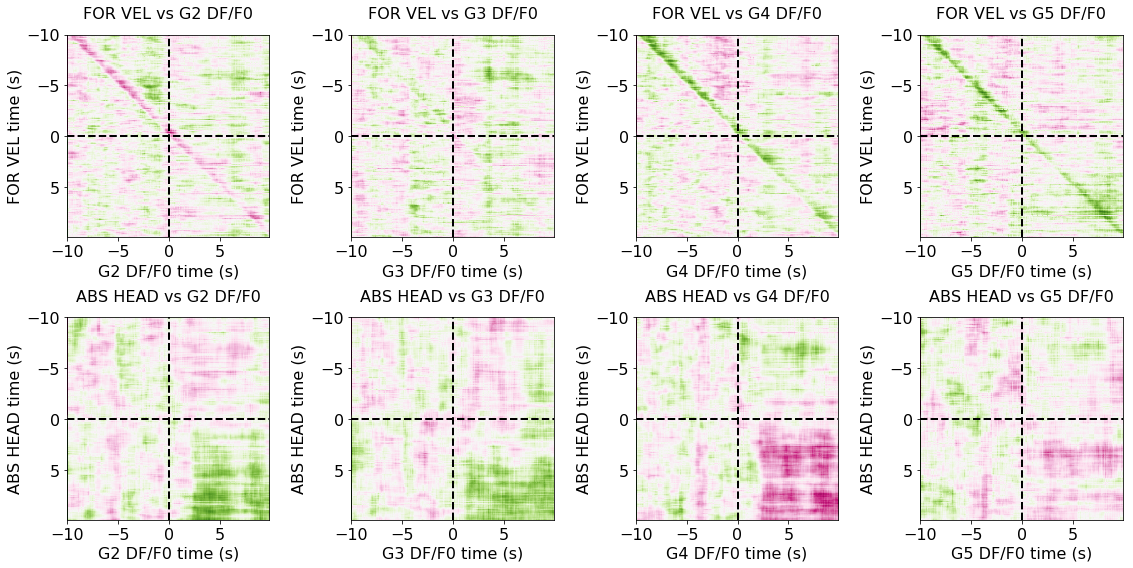

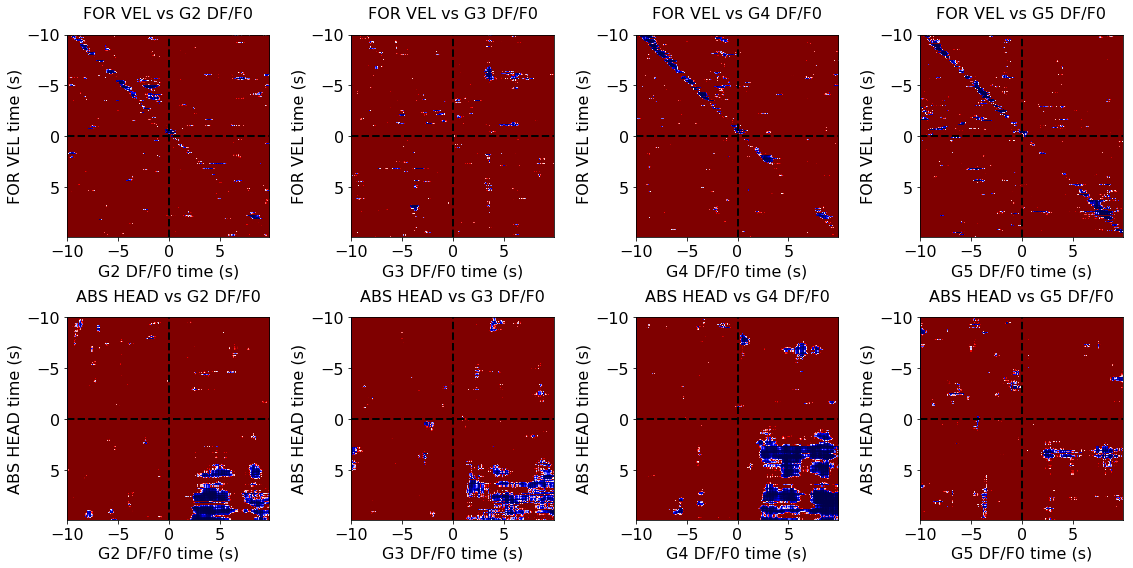

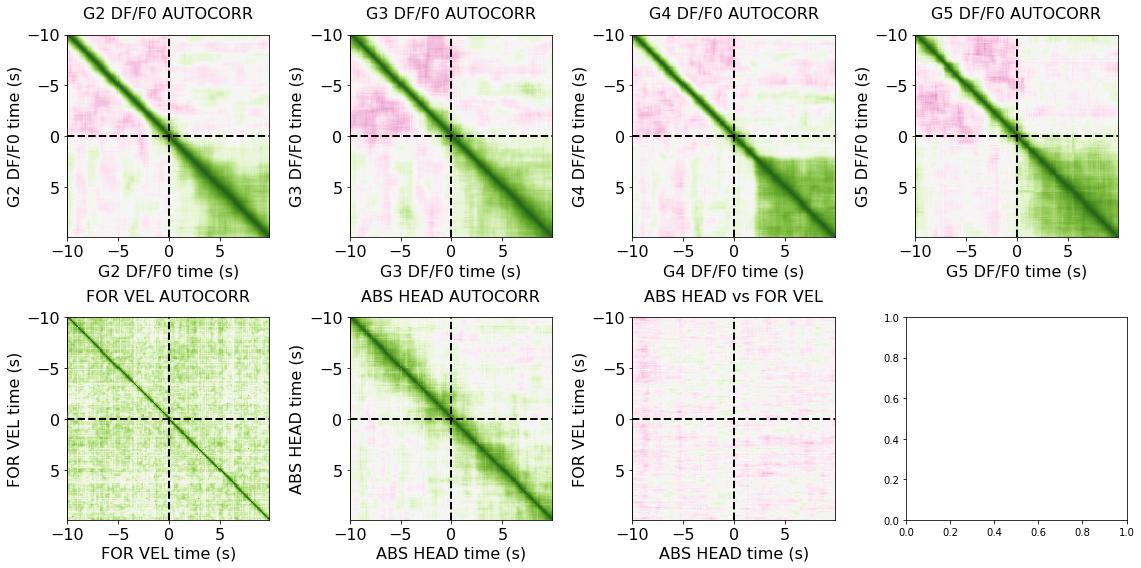

In [7]:
ctl_offset = 0

sfx = '_FALSE_ODOR_OFFSET_{}'.format(ctl_offset) if ctl_offset else ''

# cross correlations
fig_r, axs = plt.subplots(2, 4, figsize=(16, 8), tight_layout=True)

for behav, ax_row in zip(['FORVEL', 'ABSHEADING'], axs):
    for gx, ax in zip(['DFF0G2', 'DFF0G3', 'DFF0G4', 'DFF0G5'], ax_row):
        
        fn = '{}_ODOR_TRIG_XCORR_R_{}_{}{}.csv'.format(EXPT, behav, gx, sfx)
        df_r = pd.read_csv(os.path.join(SAVE_DIR, fn))
        
        ax.matshow(
            df_r, extent=[t.min(), t.max(), t.max(), t.min()],
            vmin=-.5, vmax=.5, cmap='PiYG')
        
        ax.axhline(0, color='k', lw=2, ls='--')
        ax.axvline(0, color='k', lw=2, ls='--')
        
        ax.xaxis.tick_bottom()
        
        ax.set_xlabel('{} time (s)'.format(labels[gx]))
        ax.set_ylabel('{} time (s)'.format(labels[behav]))
        
        ax.set_title('{} vs {}'.format(labels[behav], labels[gx]))
        
        set_font_size(ax, 16)
        
# p-values
fig_p, axs = plt.subplots(2, 4, figsize=(16, 8), tight_layout=True)

for behav, ax_row in zip(['FORVEL', 'ABSHEADING'], axs):
    for gx, ax in zip(['DFF0G2', 'DFF0G3', 'DFF0G4', 'DFF0G5'], ax_row):
        
        fn = '{}_ODOR_TRIG_XCORR_P_{}_{}{}.csv'.format(EXPT, behav, gx, sfx)
        df_p = pd.read_csv(os.path.join(SAVE_DIR, fn))
        
        ax.matshow(
            df_p, extent=[t.min(), t.max(), t.max(), t.min()],
            vmin=0, vmax=.02, cmap='seismic')
        
        ax.axhline(0, color='k', lw=2, ls='--')
        ax.axvline(0, color='k', lw=2, ls='--')
        
        ax.xaxis.tick_bottom()
        
        ax.set_xlabel('{} time (s)'.format(labels[gx]))
        ax.set_ylabel('{} time (s)'.format(labels[behav]))
        
        ax.set_title('{} vs {}'.format(labels[behav], labels[gx]))
        
        set_font_size(ax, 16)
        
# autocorrs
fig_a, axs = plt.subplots(2, 4, figsize=(16, 8), tight_layout=True)

for k, ax in zip(VARS, axs.flat):
    
    fn = '{}_ODOR_TRIG_XCORR_R_{}_{}{}.csv'.format(EXPT, k, k, sfx)
    df_a = pd.read_csv(os.path.join(SAVE_DIR, fn))
    
    ax.matshow(
        df_a, extent=[t.min(), t.max(), t.max(), t.min()],
        vmin=-1, vmax=1, cmap='PiYG')
        
    ax.axhline(0, color='k', lw=2, ls='--')
    ax.axvline(0, color='k', lw=2, ls='--')

    ax.xaxis.tick_bottom()

    ax.set_xlabel('{} time (s)'.format(labels[k]))
    ax.set_ylabel('{} time (s)'.format(labels[k]))

    ax.set_title('{} AUTOCORR'.format(labels[k]))

    set_font_size(ax, 16)
    
# xcor of forvel and abshead
fn = '{}_ODOR_TRIG_XCORR_R_FORVEL_ABSHEADING{}.csv'.format(EXPT, sfx)
df_x = pd.read_csv(os.path.join(SAVE_DIR, fn))

ax = axs[1, 2]

ax.matshow(
    df_x, extent=[t.min(), t.max(), t.max(), t.min()],
    vmin=-1, vmax=1, cmap='PiYG')

ax.axhline(0, color='k', lw=2, ls='--')
ax.axvline(0, color='k', lw=2, ls='--')

ax.xaxis.tick_bottom()

ax.set_xlabel('{} time (s)'.format(labels['ABSHEADING']))
ax.set_ylabel('{} time (s)'.format(labels['FORVEL']))

ax.set_title('{} vs {}'.format(labels['ABSHEADING'], labels['FORVEL']))

set_font_size(ax, 16)
    
fig_r.savefig(os.path.join(SAVE_DIR, '{}_ODOR_TRIG_XCORR_R_BEHAV_DAN{}.pdf'.format(EXPT, sfx)))
fig_p.savefig(os.path.join(SAVE_DIR, '{}_ODOR_TRIG_XCORR_P_BEHAV_DAN{}.pdf'.format(EXPT, sfx)))
fig_a.savefig(os.path.join(SAVE_DIR, '{}_ODOR_TRIG_ACORR_BEHAV_DAN{}.pdf'.format(EXPT, sfx)))

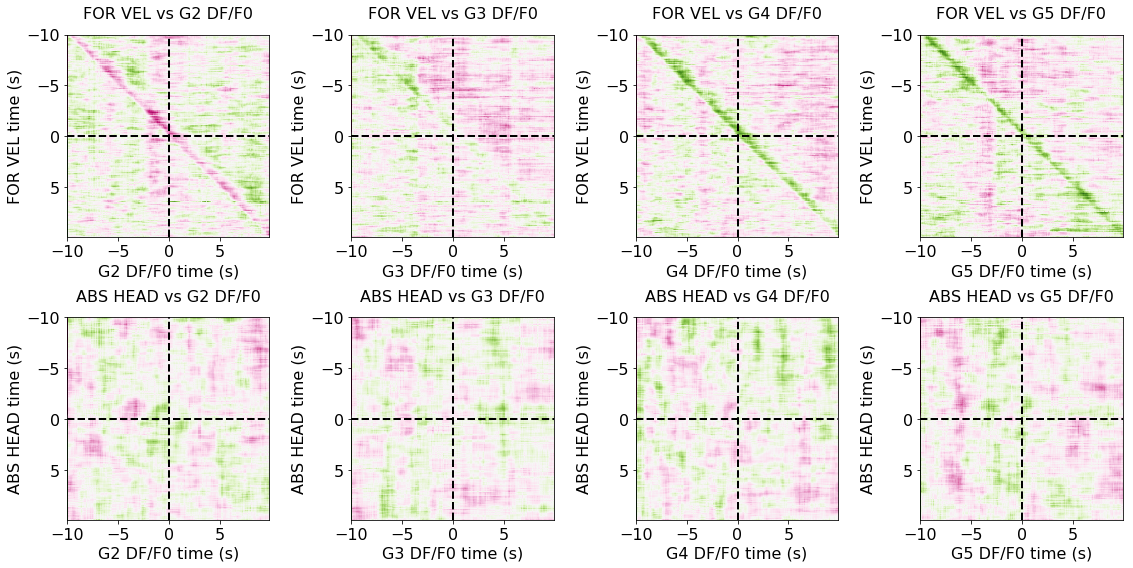

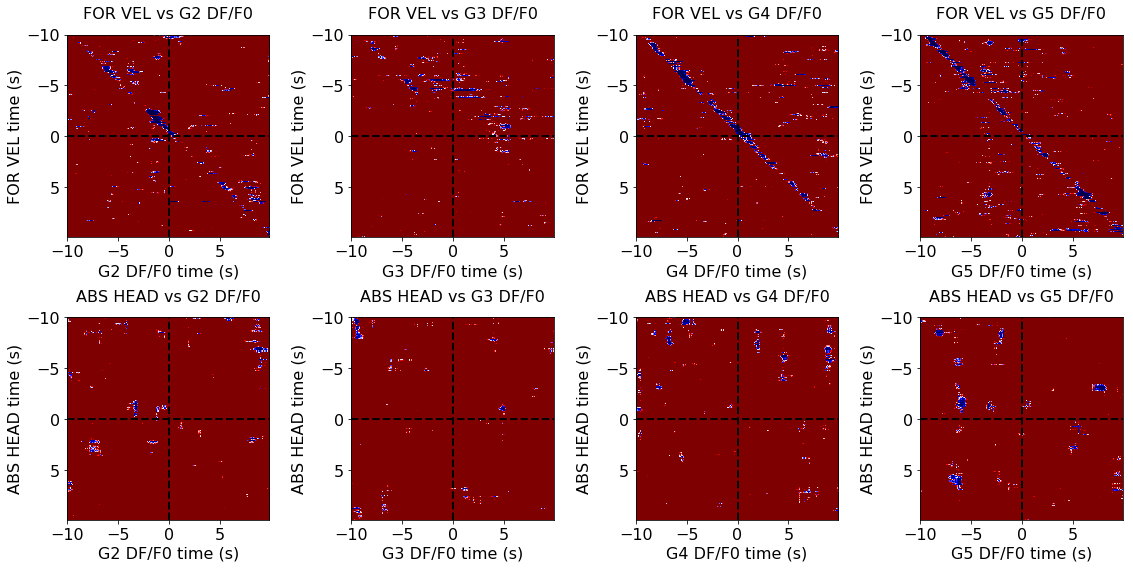

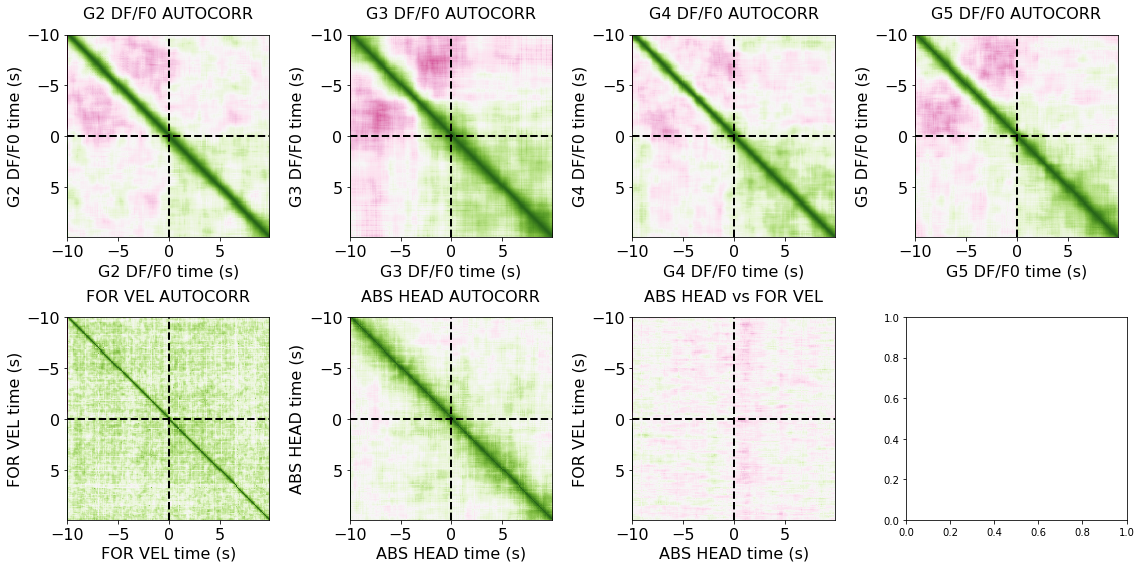

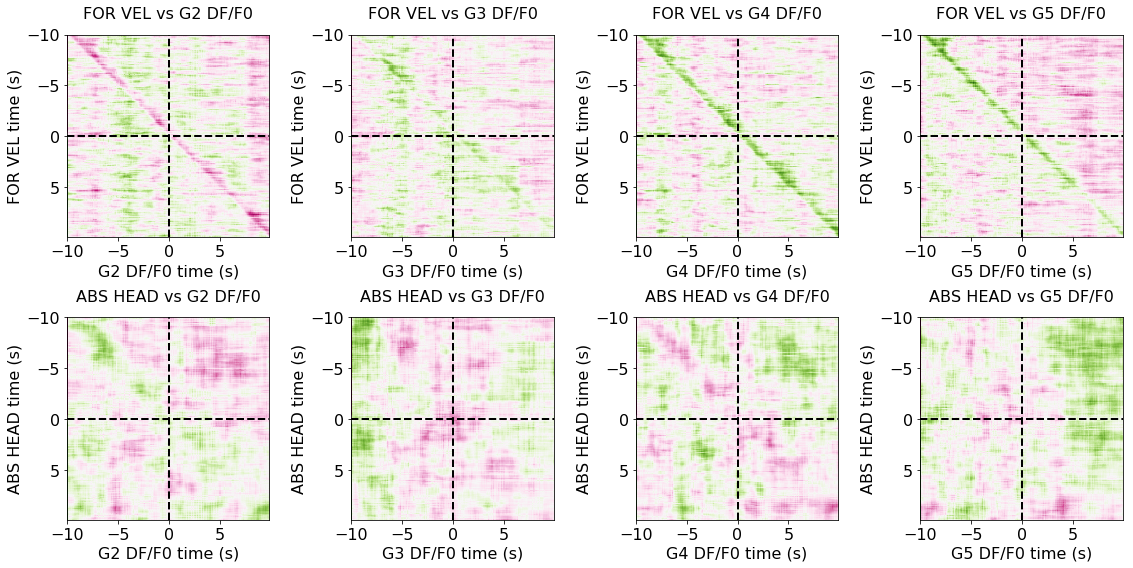

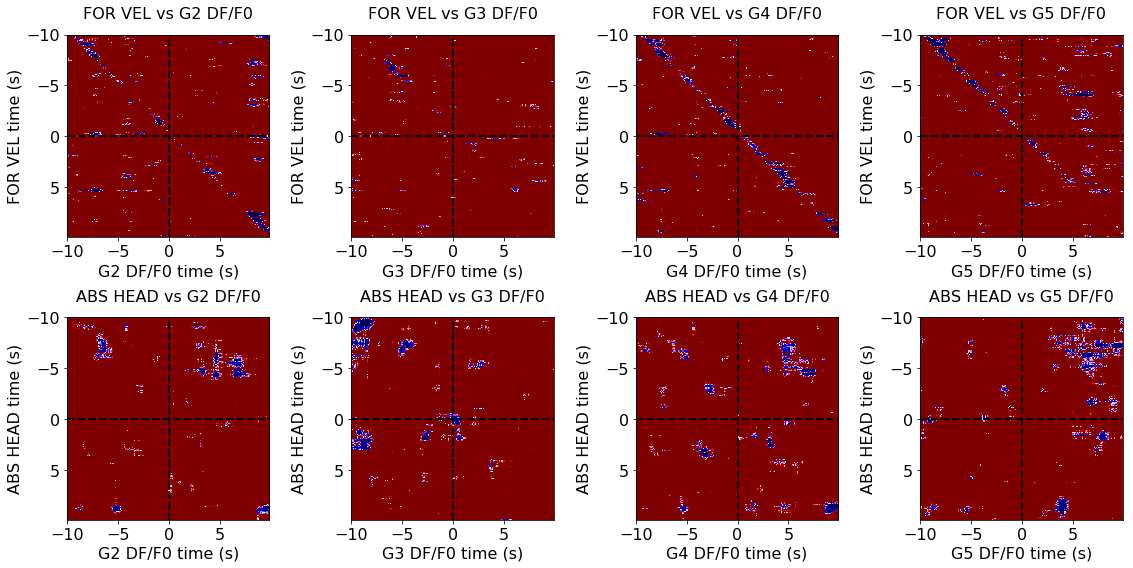

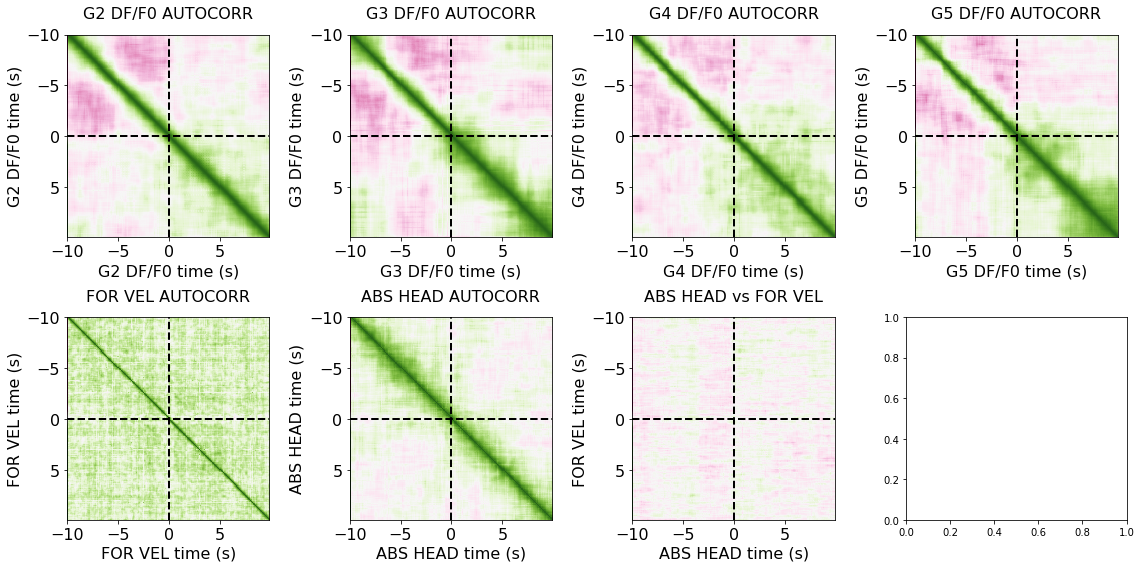

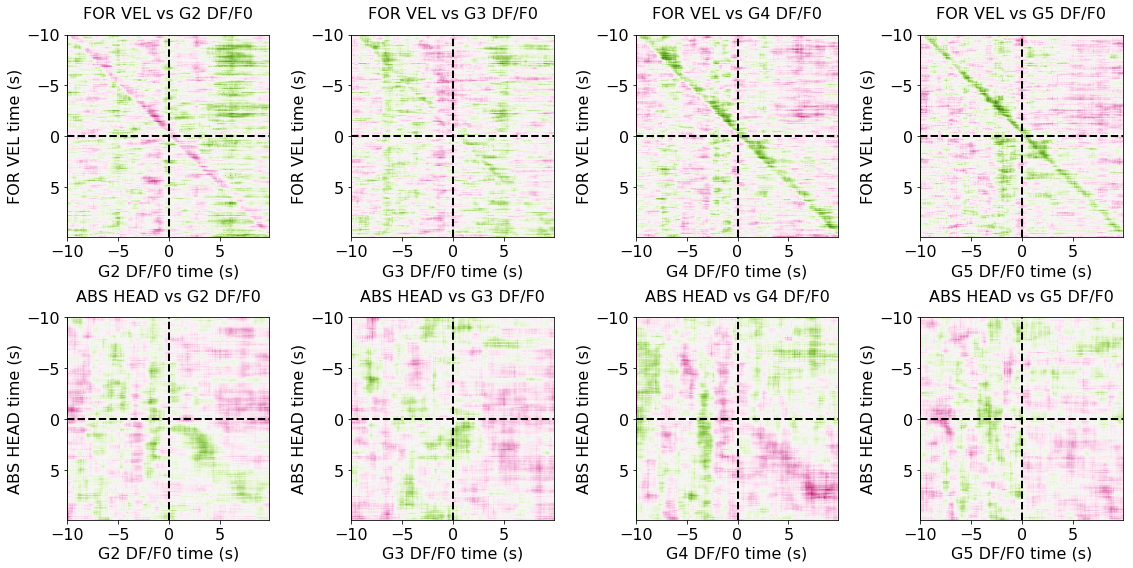

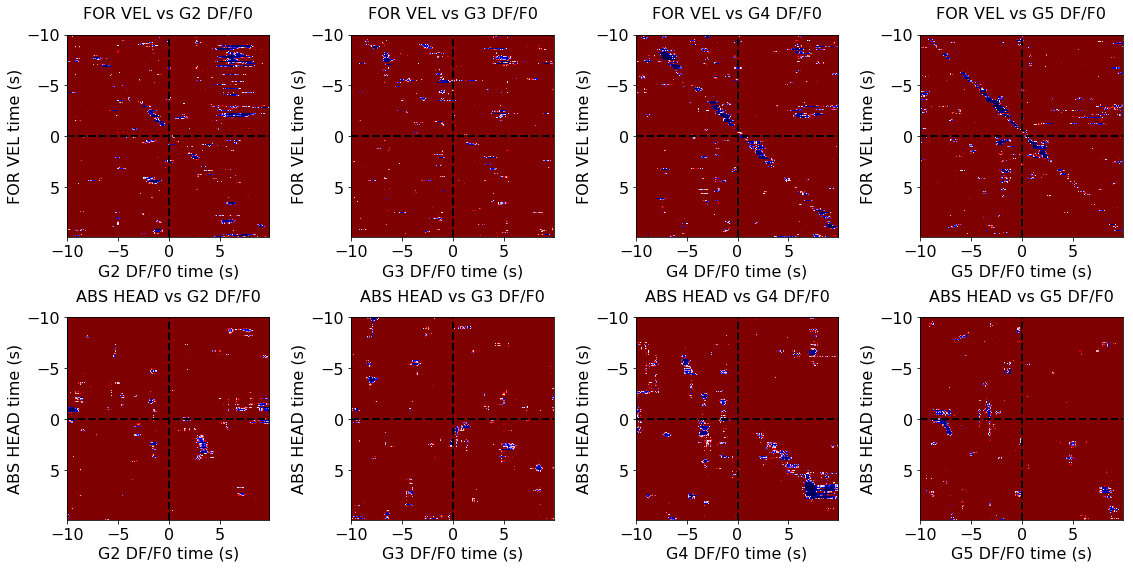

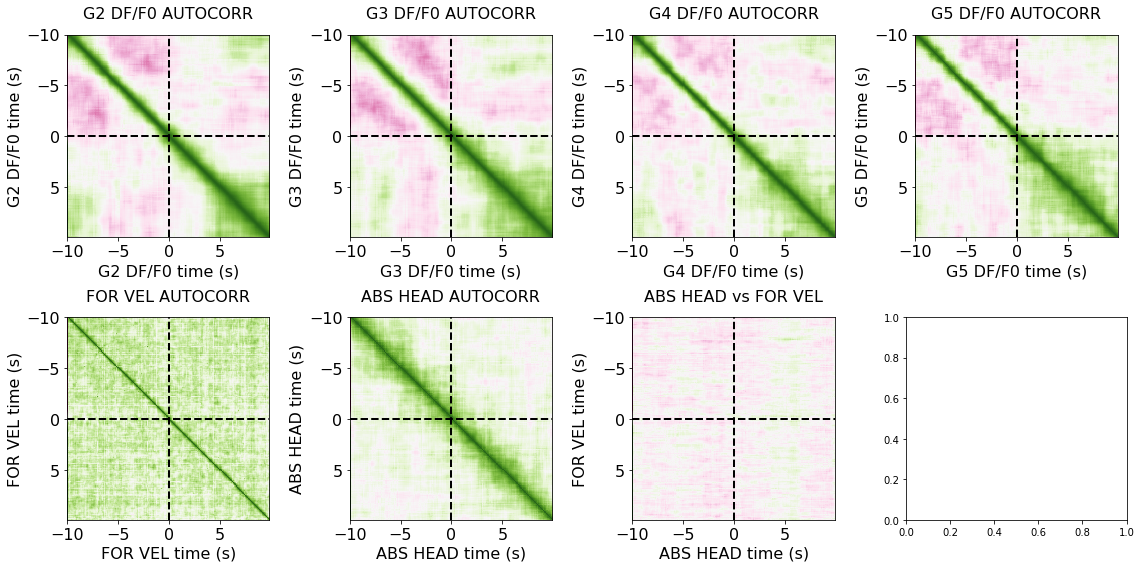

In [8]:
for ctl_offset in [-10, -20, -30]:

    sfx = '_FALSE_ODOR_OFFSET_{}'.format(ctl_offset) if ctl_offset else ''

    # cross correlations
    fig_r, axs = plt.subplots(2, 4, figsize=(16, 8), tight_layout=True)

    for behav, ax_row in zip(['FORVEL', 'ABSHEADING'], axs):
        for gx, ax in zip(['DFF0G2', 'DFF0G3', 'DFF0G4', 'DFF0G5'], ax_row):

            fn = '{}_ODOR_TRIG_XCORR_R_{}_{}{}.csv'.format(EXPT, behav, gx, sfx)
            df_r = pd.read_csv(os.path.join(SAVE_DIR, fn))

            ax.matshow(
                df_r, extent=[t.min(), t.max(), t.max(), t.min()],
                vmin=-.5, vmax=.5, cmap='PiYG')

            ax.axhline(0, color='k', lw=2, ls='--')
            ax.axvline(0, color='k', lw=2, ls='--')

            ax.xaxis.tick_bottom()

            ax.set_xlabel('{} time (s)'.format(labels[gx]))
            ax.set_ylabel('{} time (s)'.format(labels[behav]))

            ax.set_title('{} vs {}'.format(labels[behav], labels[gx]))

            set_font_size(ax, 16)

    # p-values
    fig_p, axs = plt.subplots(2, 4, figsize=(16, 8), tight_layout=True)

    for behav, ax_row in zip(['FORVEL', 'ABSHEADING'], axs):
        for gx, ax in zip(['DFF0G2', 'DFF0G3', 'DFF0G4', 'DFF0G5'], ax_row):

            fn = '{}_ODOR_TRIG_XCORR_P_{}_{}{}.csv'.format(EXPT, behav, gx, sfx)
            df_p = pd.read_csv(os.path.join(SAVE_DIR, fn))

            ax.matshow(
                df_p, extent=[t.min(), t.max(), t.max(), t.min()],
                vmin=0, vmax=.02, cmap='seismic')

            ax.axhline(0, color='k', lw=2, ls='--')
            ax.axvline(0, color='k', lw=2, ls='--')

            ax.xaxis.tick_bottom()

            ax.set_xlabel('{} time (s)'.format(labels[gx]))
            ax.set_ylabel('{} time (s)'.format(labels[behav]))

            ax.set_title('{} vs {}'.format(labels[behav], labels[gx]))

            set_font_size(ax, 16)

    # autocorrs
    fig_a, axs = plt.subplots(2, 4, figsize=(16, 8), tight_layout=True)

    for k, ax in zip(VARS, axs.flat):

        fn = '{}_ODOR_TRIG_XCORR_R_{}_{}{}.csv'.format(EXPT, k, k, sfx)
        df_a = pd.read_csv(os.path.join(SAVE_DIR, fn))

        ax.matshow(
            df_a, extent=[t.min(), t.max(), t.max(), t.min()],
            vmin=-1, vmax=1, cmap='PiYG')

        ax.axhline(0, color='k', lw=2, ls='--')
        ax.axvline(0, color='k', lw=2, ls='--')

        ax.xaxis.tick_bottom()

        ax.set_xlabel('{} time (s)'.format(labels[k]))
        ax.set_ylabel('{} time (s)'.format(labels[k]))

        ax.set_title('{} AUTOCORR'.format(labels[k]))

        set_font_size(ax, 16)
        
    # xcor of forvel and abshead
    fn = '{}_ODOR_TRIG_XCORR_R_FORVEL_ABSHEADING{}.csv'.format(EXPT, sfx)
    df_x = pd.read_csv(os.path.join(SAVE_DIR, fn))

    ax = axs[1, 2]

    ax.matshow(
        df_x, extent=[t.min(), t.max(), t.max(), t.min()],
        vmin=-1, vmax=1, cmap='PiYG')

    ax.axhline(0, color='k', lw=2, ls='--')
    ax.axvline(0, color='k', lw=2, ls='--')

    ax.xaxis.tick_bottom()

    ax.set_xlabel('{} time (s)'.format(labels['ABSHEADING']))
    ax.set_ylabel('{} time (s)'.format(labels['FORVEL']))

    ax.set_title('{} vs {}'.format(labels['ABSHEADING'], labels['FORVEL']))

    set_font_size(ax, 16)
        
    fig_r.savefig(os.path.join(SAVE_DIR, '{}_ODOR_TRIG_XCORR_R_BEHAV_DAN{}.pdf'.format(EXPT, sfx)))
    fig_p.savefig(os.path.join(SAVE_DIR, '{}_ODOR_TRIG_XCORR_P_BEHAV_DAN{}.pdf'.format(EXPT, sfx)))
    fig_a.savefig(os.path.join(SAVE_DIR, '{}_ODOR_TRIG_ACORR_BEHAV_DAN{}.pdf'.format(EXPT, sfx)))